<a href="https://colab.research.google.com/github/kaung-htet-myat/Multi-teachers-Knowledge-Distillation/blob/master/Models_for_MulTeachers_KD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import scipy as sp
from scipy.stats import entropy

from nets.keras_resnet import resnet_v1, resnet_v2

## Data Loading

In [ ]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()
train_data, test_data = train_data.astype('float32')/255. , test_data.astype('float32')/255.
train_labels, test_labels = train_labels.astype('int32'), test_labels.astype('int32')

x_train_mean = np.mean(train_data, axis=0)
train_data -= x_train_mean
test_data -= x_train_mean

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

def random_shift(image):
    return  tf.keras.preprocessing.image.random_shift(image, 0.1, 0.1,  row_axis=0, col_axis=1, channel_axis=2)

def augment(image, label):
    image = tf.numpy_function(random_shift, [image], tf.float32)
    image = tf.image.random_flip_left_right(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_ds = train_ds.shuffle(10000, seed=seed)
train_ds = train_ds.map(augment)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
train_steps_per_epoch = tf.data.experimental.cardinality(train_ds)

test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

print(train_data.shape)
print(train_labels.shape)
print(test_labels.shape)

## Resnet20

In [ ]:
# Resnet 20
resnet_20 = resnet_v1(input_shape=(32,32,3), depth= 20, num_classes=10)
resnet_20.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
def lr_schedule(epoch):
  lr = 1e-3
  if epoch>=10:
    lr*= 1e-1
  elif epoch>=25:
    lr*= 1e-2
  elif epoch>=40:
    lr*= 1e-3
  return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [ ]:
filepath = ('models/resnet_20_cp/cp.ckpt')

rn20_cp = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

time_rn20 = TimingCallback()

In [ ]:
resnet_20.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rn20_hist = resnet_20.fit(train_ds, epochs=50, validation_data=(test_ds), callbacks=[lr_scheduler, rn20_cp, time_rn20])

In [ ]:
print("Resnet20 trianing time:", sum(time_rn20.logs))

Resnet20 trianing time: 3222.6004266680006


In [ ]:
resnet_20.evaluate(test_data, test_labels)

313/313 [==============================] - 3s 10ms/step - loss: 0.5051 - accuracy: 0.8766


[0.5051367878913879, 0.8766000270843506]

In [ ]:
resnet_20.save('models/resnet_20')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/MulTeacher Models/resnet_20/assets


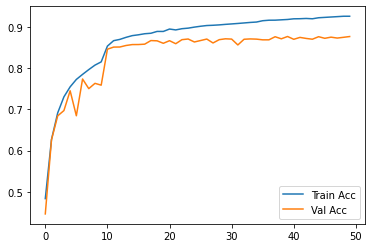

In [ ]:
plt.figure()
plt.plot(rn20_hist.history['accuracy'], label= 'Train Acc')
plt.plot(rn20_hist.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

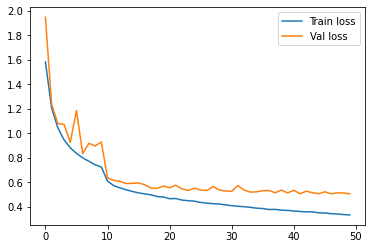

In [ ]:
plt.figure()
plt.plot(rn20_hist.history['loss'], label= 'Train loss')
plt.plot(rn20_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

## Resnet32

In [ ]:
# Resnet32

resnet_32 = resnet_v1(input_shape=(32,32,3), depth= 32, num_classes=10)
resnet_32.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [ ]:
filepath = ('models/resnet_32_cp/cp.ckpt')

rn32_cp = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

time_rn32 = TimingCallback()

In [ ]:
resnet_32.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rn32_hist = resnet_32.fit(train_ds, epochs=50, validation_data=(test_ds), callbacks=[lr_scheduler, rn32_cp, time_rn32])

In [ ]:
print("Resnet32 trianing time:", sum(time_rn32.logs))

Resnet32 trianing time: 3435.802752089999


In [ ]:
resnet_32.evaluate(test_data, test_labels)

313/313 [==============================] - 4s 12ms/step - loss: 0.5683 - accuracy: 0.8672


[0.5682622194290161, 0.8672000169754028]

In [ ]:
resnet_32.save('models/resnet_32')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/MulTeacher Models/resnet_32/assets


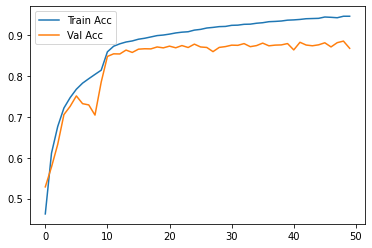

In [ ]:
plt.figure()
plt.plot(rn32_hist.history['accuracy'], label= 'Train Acc')
plt.plot(rn32_hist.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

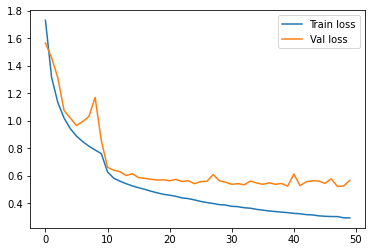

In [ ]:
plt.figure()
plt.plot(rn32_hist.history['loss'], label= 'Train loss')
plt.plot(rn32_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

## Resnet14

In [ ]:
# Resnet14

resnet_14 = resnet_v1(input_shape=(32,32,3), depth=14, num_classes=10)
resnet_14.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
filepath = ('models/resnet_14_cp/cp.ckpt')

rn14_cp = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

time_rn14 = TimingCallback()

In [ ]:
resnet_14.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rn14_hist = resnet_14.fit(train_ds, epochs=50, validation_data=(test_ds), callbacks=[lr_scheduler, time_rn14])

In [ ]:
print("Resnet14 trianing time:", sum(time_rn14.logs))

In [ ]:
resnet_14.evaluate(test_data, test_labels)

In [ ]:
resnet_14.save('models/resnet_14')

INFO:tensorflow:Assets written to: /content/drive/My Drive/MulTeacher Models/resnet_14/assets


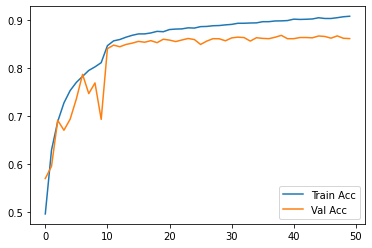

In [ ]:
plt.figure()
plt.plot(rn14_hist.history['accuracy'], label= 'Train Acc')
plt.plot(rn14_hist.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

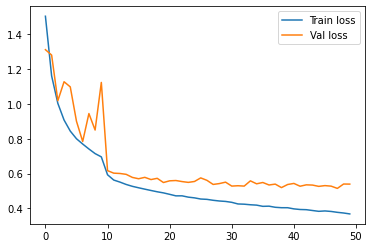

In [ ]:
plt.figure()
plt.plot(rn14_hist.history['loss'], label= 'Train loss')
plt.plot(rn14_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

## Resnet44

In [ ]:
# Resnet44

resnet_44 = resnet_v1(input_shape=(32,32,3), depth=44, num_classes=10)
resnet_44.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 32, 32, 16)   64          conv2d_69[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 32, 32, 16)   0           batch_normalization_63[0][0]     
____________________________________________________________________________________________

In [ ]:
filepath = ('models/resnet_44_cp/cp.ckpt')

rn44_cp = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

time_rn44 = TimingCallback()

In [ ]:
resnet_44.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rn44_hist = resnet_44.fit(train_ds, epochs=50, validation_data=(test_ds), callbacks=[lr_scheduler, rn44_cp, time_rn44])

In [ ]:
print("Resnet44 trianing time:", sum(time_rn44.logs))

Resnet44 trianing time: 4453.478673890002


In [ ]:
resnet_44.evaluate(test_data, test_labels)

313/313 [==============================] - 5s 16ms/step - loss: 0.5796 - accuracy: 0.8735


[0.5796104073524475, 0.8734999895095825]

In [ ]:
resnet_44.save('models/resnet_44')

INFO:tensorflow:Assets written to: /content/drive/My Drive/MulTeacher Models/resnet_44/assets


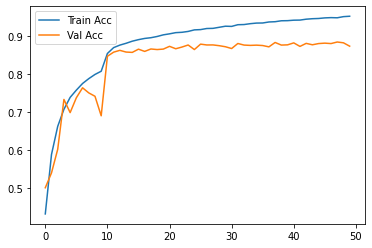

In [ ]:
plt.figure()
plt.plot(rn44_hist.history['accuracy'], label= 'Train Acc')
plt.plot(rn44_hist.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

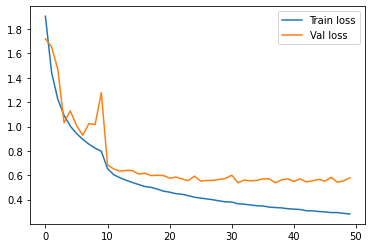

In [ ]:
plt.figure()
plt.plot(rn44_hist.history['loss'], label= 'Train loss')
plt.plot(rn44_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.show()